In [1]:
#Upload kml file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,skew
from scipy import stats
from sklearn.neighbors import KDTree
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNetCV, LassoCV,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from pykml import parser
with open('../Resources/glims_polygons.kml', 'r', encoding="utf-8") as f:
   root = parser.parse(f).getroot()
#Put kml to dataframe  
places = []
for place in root.Document.Folder.Placemark:
    data = {item.get("name"): item.text for item in
            place.ExtendedData.SchemaData.SimpleData}
    coords = place.Polygon.outerBoundaryIs.LinearRing.coordinates.text.strip()
    data["Coordinates"] = coords
    places.append(data)
df = pd.DataFrame(places)
# print(df)

In [2]:
cleaned_df = df[['line_type','anlys_id','area','glac_id','anlys_time',
               'src_date','db_area','min_elev','mean_elev','max_elev',
               'primeclass','Coordinates','rec_status','release_dt','gone_date',
               'glac_name','glac_stat','proc_desc','geog_area','conn_lvl',
               'surge_type','term_type','gtng_o1reg','gtng_o2reg','rgi_gl_typ']]
cleaned_df.head()

# Counting initial number of rows to make sure we don't somehow lose any.
row_count = cleaned_df.shape[0]
print(f"Number of rows: {row_count}")

Number of rows: 69572


In [3]:
# cleaned_df.head()

In [4]:
# SEE ABOVE FOR DEFINITIONS. ELIMINATING PRIMECLASS, REC_STATUS, SUBM_ID, GONE_DT_E, PROC_DESC, RC_ID, GEOG_AREA, CONN_LVL, SURGE_TYPE, TERM_TYPE, GTNG_O1REG, GTNG_O2REG, RGI_GL_TYP,
# LOC_UNC_X, GLOB_UNC_Y

# SOME ARE NOTES, SOME ARE DEFINITIONS RELEVANT TO SOMEONE. LIKELY NOT TO US. REC_STATUS HAD ONE VALUE; 'OKAY'.

#cleaned_df_2 = df[['line_type','anlys_id','area','glac_id','anlys_time','db_area','min_elev','mean_elev','max_elev','Coordinates','src_date','glac_name','glac_stat',
#'gone_date','release_dt']]

In [5]:
# making a df copy
#cleaned_df_3 = cleaned_df_2.copy()

# glac_stat has two unique values. replaced exists with e and gone with g
#cleaned_df_3['glac_stat'] = cleaned_df_3['glac_stat'].replace({'gone': 'g', 'exists': 'e'})

# line_type has three unique values. Replaced debris_cov with dc, glac_bound with gb, intrnl_rock with ir
#cleaned_df_3['line_type'] = cleaned_df_3['line_type'].replace({'debris_cov': 'dc', 'glac_bound': 'gb', 'intrnl_rock': 'ir'})

cleaned_df_3 = cleaned_df

In [6]:
# Changed the times which were strings to times that are datetime objects. Took away the hour and rounded off to a day, which
# wasn't intentional, but we don't need hourly resolution for a measurement of an object that changes very slowly
# and that we are only seeing measurements for a few times per year at most

cleaned_df_3['src_date'] = pd.to_datetime(cleaned_df_3['src_date'])
cleaned_df_3['anlys_time'] = pd.to_datetime(cleaned_df_3['anlys_time'])
cleaned_df_3['release_dt'] = pd.to_datetime(cleaned_df_3['release_dt'])


# Converted the times to unix. Unix times before 1/1/1970 are negative numbers, descending from 0 below 1/1/1970, so they'll still work and be
# convertible and comparable.
# Of note, minimum recording is 12/13/1901, so if there were dates before that, this would not be feasible.

cleaned_df_3['src_date'] = cleaned_df_3['src_date'].apply(lambda x: int(x.timestamp()))
cleaned_df_3['anlys_time'] = cleaned_df_3['anlys_time'].apply(lambda x: int(x.timestamp()))
cleaned_df_3['release_dt'] = cleaned_df_3['release_dt'].apply(lambda x: int(x.timestamp()))

# format for gone_date. the object wasn't recognized as a time like the other was, so I explicitly defined the format.
gone_date_raw_format = '%Y-%m-%d'

# Converting gone_date to datetime.
cleaned_df_3['gone_date'] = pd.to_datetime(cleaned_df_3['gone_date'], format=gone_date_raw_format, errors='coerce')

# Converting gone_date to unix. If the glacier still exists, it's a NaT, so replacing it with e for exists.
nat_replace_if_exists = 'e'
cleaned_df_3['gone_date'] = cleaned_df_3['gone_date'].apply(
    lambda x: int(x.timestamp()) if pd.notna(x) else nat_replace_if_exists
)

C:\Users\cruza\AppData\Local\Temp\ipykernel_66024\679531432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_3['src_date'] = pd.to_datetime(cleaned_df_3['src_date'])
C:\Users\cruza\AppData\Local\Temp\ipykernel_66024\679531432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_3['anlys_time'] = pd.to_datetime(cleaned_df_3['anlys_time'])
C:\Users\cruza\AppData\Local\Temp\ipykernel_66024\679531432.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [7]:
# Copying data frame

cleaned_df_4 = cleaned_df_3.copy()

# Converting columns to float. errors='coerce' won't effect 0 values, but any non-number will be converted to nan. Will print between this conversion and
# the formatting just to make sure.

cleaned_df_4['area'] = pd.to_numeric(cleaned_df_4['area'], errors='coerce')
cleaned_df_4['db_area'] = pd.to_numeric(cleaned_df_4['db_area'], errors='coerce')

nat_replace = 'x'

# nan_rows # no nan rows for either area or db_area, so we're good, per the below check.
# nan_rows = cleaned_df_4[cleaned_df_4['db_area'].isna()]

# converting to float with the trailing digits removed. The number is the number of the significant digits we round to.

for column in ['area', 'db_area']:
    cleaned_df_4[column] = cleaned_df_4[column].apply(lambda x: '{:.15g}'.format(x) if pd.notnull(x) else nat_replace)



In [8]:
# Drop the analysis ID column for cleaned_df_5. We LIKELY don't need it.

cleaned_df_5 = cleaned_df_4.drop(columns=['anlys_id'])

In [9]:
filter_value = 'Yalik Glacier'

filtered_df_1 = cleaned_df_5[cleaned_df_5['glac_name'] == filter_value]

filtered_df_1

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,gone_date,glac_name,glac_stat,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ
36509,glac_bound,51.73,G209221E59477N,1277856000,1247097600,47.8702,0,0,0,0,...,e,Yalik Glacier,exists,Various (GlobGlacier),0,0,9,1,4,None
46754,glac_bound,41.538,G209221E59477N,1437004800,1121817600,41.538,42,0,1552,0,...,e,Yalik Glacier,exists,Randolph Glacier Inventory; Umbrella RC for me...,0,0,9,1,4,299
58969,glac_bound,0,G209221E59477N,1662681600,1472601600,33.8425,0,0,0,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None
59752,glac_bound,0,G209221E59477N,1662681600,526867200,43.7459,0,0,0,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None
60794,glac_bound,0,G209221E59477N,1662681600,808876800,40.9947,0,0,0,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None
62390,glac_bound,41.538,G209221E59477N,1670630400,1121817600,40.9931,42,0,1552,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None
62780,glac_bound,41.538,G209214E59534N,1670630400,1121817600,0.10758,42,0,1552,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None
62833,glac_bound,41.538,G209214E59535N,1670630400,1121817600,0.149888,42,0,1552,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None
63723,glac_bound,41.538,G209213E59534N,1670630400,1121817600,0.126632,42,0,1552,0,...,e,Yalik Glacier,exists,Kenai Peninsula,0,0,9,1,4,None


In [10]:
# We still have the same number of rows. Check the cell above that lists row count for cleaned_df
row_count = cleaned_df_5.shape[0]
print(f"Number of rows: {row_count}")

Number of rows: 69572


In [11]:
cleaned_df_6 = cleaned_df_5.copy()
#Put in first coordinate column to split the coordinates latitude and longitude
cleaned_df_6['first_coordinate'] = cleaned_df_6['Coordinates'].apply(lambda x: x.split(',0')[0])

cleaned_df_6

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,glac_name,glac_stat,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Brady Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-136.675873,58.385483"
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,Marvine/Hayden Glacier,exists,Various (NSIDC),0,0,9,1,5,None,"-140.10202,59.96069"
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,Johns Hopkins Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-137.260638,58.805875"
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Brady Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-136.662581,58.464275"
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Brady Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-136.652551,58.490007"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,None,exists,Conterminous USA,0,0,9,2,5,None,"-105.690397,40.449164"
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,None,exists,Conterminous USA,0,0,9,2,4,None,"-121.193295,48.16877"
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,None,exists,Conterminous USA,0,0,9,2,5,None,"-113.72218,45.31765"
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,Linn Glacier,exists,Conterminous USA,0,0,9,2,4,None,"-121.777004,44.173283"


In [12]:
cleaned_df_6.drop(columns=['Coordinates'], inplace=True)

cleaned_df_6

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,glac_name,glac_stat,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Brady Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-136.675873,58.385483"
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,Marvine/Hayden Glacier,exists,Various (NSIDC),0,0,9,1,5,None,"-140.10202,59.96069"
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,Johns Hopkins Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-137.260638,58.805875"
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Brady Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-136.662581,58.464275"
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Brady Glacier,exists,Various (NSIDC),0,0,9,1,6,None,"-136.652551,58.490007"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,None,exists,Conterminous USA,0,0,9,2,5,None,"-105.690397,40.449164"
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,None,exists,Conterminous USA,0,0,9,2,4,None,"-121.193295,48.16877"
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,None,exists,Conterminous USA,0,0,9,2,5,None,"-113.72218,45.31765"
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,Linn Glacier,exists,Conterminous USA,0,0,9,2,4,None,"-121.777004,44.173283"


In [13]:
cleaned_df_7 = cleaned_df_6.copy()
#Put in column separate latitude and longitude
cleaned_df_7[['lng', 'lat']] = cleaned_df_7['first_coordinate'].str.split(',', expand=True)

cleaned_df_7['lat'] = pd.to_numeric(cleaned_df_7['lat'])
cleaned_df_7['lng'] = pd.to_numeric(cleaned_df_7['lng'])

cleaned_df_7

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Various (NSIDC),0,0,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,Various (NSIDC),0,0,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,Various (NSIDC),0,0,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Various (NSIDC),0,0,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Various (NSIDC),0,0,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,Conterminous USA,0,0,9,2,5,None,"-105.690397,40.449164",-105.690397,40.449164
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,Conterminous USA,0,0,9,2,4,None,"-121.193295,48.16877",-121.193295,48.168770
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,Conterminous USA,0,0,9,2,5,None,"-113.72218,45.31765",-113.722180,45.317650
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,Conterminous USA,0,0,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283


In [14]:
#cleaned_df_7.drop(columns=['first_coordinate'], inplace=True)

avg_lat_lng_df = cleaned_df_7.groupby('glac_name')[['lat', 'lng']].mean().reset_index()

avg_lat_lng_df

#avg_lat_lng_df.to_csv('../Resources/glacier_avg_lat_lng.csv', index=False)

#cleaned_df_7.to_csv('../Resources/cleaned_df_7.csv', index=False)

,glac_name,lat,lng
0,1,61.843030,-149.484166
1,10,62.725465,-151.542192
2,100,62.927452,-150.794716
3,1000,63.093233,-150.569552
4,1001,63.093039,-150.545448
...,...,...,...
1650,Yalik Glacier,59.538355,-150.794766
1651,Yanert Glacier,63.604379,-147.616594
1652,Yawning Glacier,48.448965,-121.034797
1653,Yentna Glacier,62.930110,-151.443491


C:\Users\cruza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


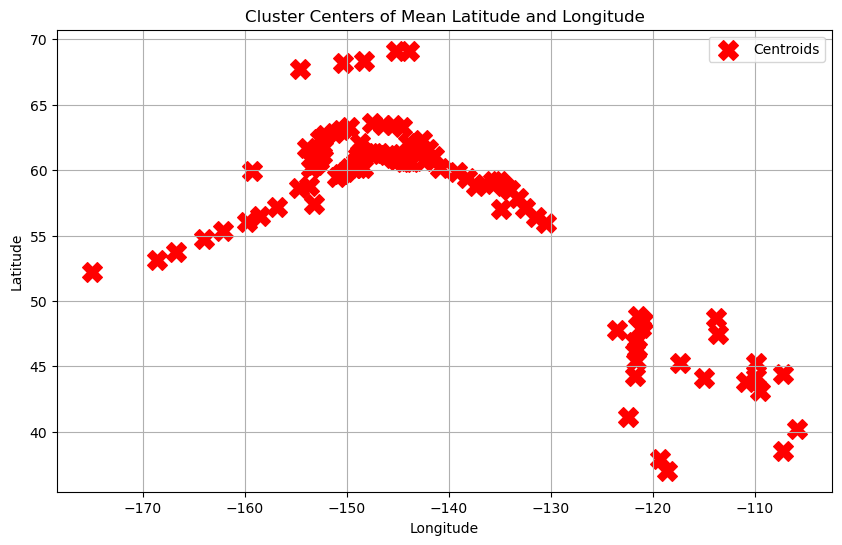

In [15]:
#Create regions for latitude and longitude for better model performance according to 
#https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c
# Define the number of clusters
num_clusters = 100

# Initialize KMeans with the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the KMeans model
cleaned_df_7[['lat', 'lng']] = cleaned_df_7[['lat', 'lng']].astype(float)
cleaned_df_7['cluster'] = kmeans.fit_predict(cleaned_df_7[['lat', 'lng']])

# Calculate the average coordinates for each cluster
cluster_means = cleaned_df_7.groupby('cluster')[['lat', 'lng']].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot cluster centers
plt.scatter(cluster_means['lng'], cluster_means['lat'], c='red', s=200, marker='X', label='Centroids')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers of Mean Latitude and Longitude')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

cluster_means.to_csv('../Resources/100_cluster_means.csv')

In [16]:
# Convert cluster means to DataFrame
cluster_means_df = pd.DataFrame(cluster_means, columns=['lat', 'lng'])

# Create a column 'cluster_id' for index purposes starting at 1
cluster_means_df['cluster_id'] = range(1, len(cluster_means_df) + 1)

# Set 'cluster_id' as the index
cluster_means_df.set_index('cluster_id', inplace=True)

kdtree = KDTree(cluster_means_df[['lat', 'lng']].values)

In [54]:
data_coords = cleaned_df_7[['lat', 'lng']].values

distances, indices = kdtree.query(data_coords)

indices = indices.flatten()

In [55]:
cleaned_df_7['closest_cluster_lat'] = cluster_means_df['lat'].iloc[indices].values
cleaned_df_7['closest_cluster_lng'] = cluster_means_df['lng'].iloc[indices].values

cleaned_df_7

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,9,2,5,None,"-105.690397,40.449164",-105.690397,40.449164,3,40.219607,-105.876157
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,9,2,4,None,"-121.193295,48.16877",-121.193295,48.168770,36,47.921442,-121.151517
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,9,2,5,None,"-113.72218,45.31765",-113.722180,45.317650,30,44.069954,-114.970348
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283,72,44.229202,-121.769272


In [56]:
# Filter the DataFrame
filtered_df = cleaned_df_7[cleaned_df_7['area'] != '0']

# Print the filtered DataFrame
filtered_df

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
14009,glac_bound,0.777,G222822E58665N,1437004800,1284508800,0.776922,2496,0,3879,0,...,9,1,6,19,"-137.171531,58.66963",-137.171531,58.669630,38,58.781558,-137.303258
14010,glac_bound,0.033,G210987E61166N,1437004800,1249257600,0.033314,1289,0,1404,0,...,9,1,4,99,"-149.01278,61.167452",-149.012780,61.167452,96,61.066698,-148.962231
14011,glac_bound,8.838,G217968E60885N,1437004800,1284249600,8.83774,1560,0,2410,0,...,9,1,5,99,"-141.998262,60.876832",-141.998262,60.876832,63,60.671605,-142.483219
14012,glac_bound,0.192,G206922E60614N,1437004800,1284249600,0.191698,1200,0,1636,0,...,9,1,2,99,"-153.074529,60.612969",-153.074529,60.612969,82,60.363570,-153.087596
14013,glac_bound,0.059,G211115E62068N,1437004800,1249257600,0.059431,2044,0,2316,0,...,9,1,4,99,"-148.886227,62.070393",-148.886227,62.070393,53,62.066445,-148.716948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,9,2,5,None,"-105.690397,40.449164",-105.690397,40.449164,3,40.219607,-105.876157
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,9,2,4,None,"-121.193295,48.16877",-121.193295,48.168770,36,47.921442,-121.151517
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,9,2,5,None,"-113.72218,45.31765",-113.722180,45.317650,30,44.069954,-114.970348
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283,72,44.229202,-121.769272


In [57]:
# Filter the DataFrame
filtered_df_carrie = cleaned_df_7[cleaned_df_7['glac_name'] == 'Carrie Glacier']

# Print the filtered DataFrame
filtered_df_carrie

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
41523,glac_bound,0.398177,G236365E47891N,1508803200,1438387200,0.398473,0,0,0,0,...,9,2,4,None,"-123.637759,47.893938",-123.637759,47.893938,1,47.776271,-123.499451
49186,glac_bound,0.915,G236365E47891N,1154390400,-830390400,0.915113,1556,0,2039,0,...,9,2,4,None,"-123.62522,47.895612",-123.625220,47.895612,1,47.776271,-123.499451
66593,glac_bound,0.107749,G236364E47890N,1676505600,1441756800,0.10775,0,0,0,6,...,9,2,4,None,"-123.629373,47.888791",-123.629373,47.888791,1,47.776271,-123.499451
69571,glac_bound,0.391326,G236365E47891N,1676505600,1441756800,0.391327,0,0,0,6,...,9,2,4,None,"-123.63685,47.891797",-123.636850,47.891797,1,47.776271,-123.499451


In [58]:
cleaned_df_8 = cleaned_df_7.copy()

# cleaned_df_8 = cleaned_df_8[cleaned_df_8['area'] != '0']
cleaned_df_8 = cleaned_df_8[cleaned_df_8['glac_name'] != 'None']

cleaned_df_8

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69563,glac_bound,0.610026,G236663E47729N,1676505600,1441756800,0.610024,0,0,0,6,...,9,2,4,None,"-123.337537,47.724574",-123.337537,47.724574,1,47.776271,-123.499451
69564,glac_bound,0.01021,G238715E48917N,1676505600,1441756800,0.010209,0,0,0,7,...,9,2,4,None,"-121.284829,48.915118",-121.284829,48.915118,21,48.822003,-121.471780
69565,glac_bound,2.18024,G238901E48124N,1676505600,1441756800,2.18024,0,0,0,6,...,9,2,4,None,"-121.0775,48.117744",-121.077500,48.117744,36,47.921442,-121.151517
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283,72,44.229202,-121.769272


In [60]:
counts = cleaned_df_8['glac_name'].value_counts()

cleaned_df_9 = cleaned_df_8[cleaned_df_8['glac_name'].isin(counts[counts >= 2].index)]

cleaned_df_9

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69561,glac_bound,0.01665,G236764E47851N,1676505600,1441756800,0.016653,0,0,0,7,...,9,2,4,None,"-123.235694,47.850382",-123.235694,47.850382,1,47.776271,-123.499451
69563,glac_bound,0.610026,G236663E47729N,1676505600,1441756800,0.610024,0,0,0,6,...,9,2,4,None,"-123.337537,47.724574",-123.337537,47.724574,1,47.776271,-123.499451
69564,glac_bound,0.01021,G238715E48917N,1676505600,1441756800,0.010209,0,0,0,7,...,9,2,4,None,"-121.284829,48.915118",-121.284829,48.915118,21,48.822003,-121.471780
69565,glac_bound,2.18024,G238901E48124N,1676505600,1441756800,2.18024,0,0,0,6,...,9,2,4,None,"-121.0775,48.117744",-121.077500,48.117744,36,47.921442,-121.151517


In [61]:
cleaned_df_10 = cleaned_df_9.copy()

# Convert 'area' to numeric type
cleaned_df_10['area'] = pd.to_numeric(cleaned_df_10['area'])

# Sort by glacier name and time (Unix timestamps)
cleaned_df_11 = cleaned_df_10.sort_values(by=['glac_name', 'anlys_time'])

# Keep only the first occurrence for each timestamp within each glacier
cleaned_df_11 = cleaned_df_11.drop_duplicates(subset=['glac_name', 'anlys_time'], keep='first')

# Find the initial area value for each glac_name
initial_area = cleaned_df_11.groupby('glac_name')['area'].transform('first')

# Convert 'initial_area' to numeric type (if necessary)
initial_area = pd.to_numeric(initial_area)

# Set the initial value to 100
cleaned_df_11['percent_area'] = 100 + (cleaned_df_11['area'] - initial_area) / initial_area * 100



In [62]:
# Calculate counts for each glac_name
counts = cleaned_df_11['glac_name'].value_counts()

# Identify glac_name values that occur more than once
valid_glac_names = counts[counts > 1].index

# Filter DataFrame to keep only rows with glac_name in valid_glac_names
cleaned_df_11 = cleaned_df_11[cleaned_df_11['glac_name'].isin(valid_glac_names)]

cleaned_df_11

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng,percent_area
42930,glac_bound,0.000000,G207293E62414N,1262304000,1060387200,0,0,0,0,0,...,1,2,None,"-152.706301,62.414146",-152.706301,62.414146,92,62.385977,-152.669199,NaN
42439,glac_bound,0.000000,G213728E61274N,1263513600,1184544000,0.177109,0,0,0,0,...,1,4,None,"-146.26203,61.271914",-146.262030,61.271914,41,61.148064,-146.055955,NaN
43053,glac_bound,0.000000,G207492E62417N,1262304000,1060387200,0,0,0,0,0,...,1,2,None,"-152.505837,62.413476",-152.505837,62.413476,92,62.385977,-152.669199,NaN
39209,glac_bound,0.000000,G209419E63037N,1302825600,-473385600,0.017771,0,0,0,0,...,1,2,None,"-150.578547,63.037453",-150.578547,63.037453,64,63.041541,-150.570598,NaN
43234,glac_bound,0.000000,G209936E63244N,1262304000,1060387200,0.299353,0,0,0,0,...,1,2,None,"-150.061016,63.24851",-150.061016,63.248510,18,63.329569,-149.779326,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43174,glac_bound,0.000000,G208382E62801N,1262304000,1060387200,379.897,0,0,0,0,...,1,2,None,"-151.441881,62.943456",-151.441881,62.943456,33,62.869188,-151.305469,NaN
38883,glac_bound,0.000000,G208382E62801N,1302825600,-536457600,392.112,0,0,0,0,...,1,2,None,"-151.34927,62.901418",-151.349270,62.901418,33,62.869188,-151.305469,NaN
44809,glac_bound,211.148000,G208382E62801N,1437004800,1284249600,387.383,263,0,3393,0,...,1,2,39,"-151.540907,62.932107",-151.540907,62.932107,33,62.869188,-151.305469,inf
49247,glac_bound,3.116000,G238278E45362N,1154390400,-420076800,3.11621,1803,0,3142,0,...,2,4,None,"-121.70245,45.370953",-121.702450,45.370953,16,45.380351,-121.694008,100.000000


In [64]:
rows_with_zero_area = cleaned_df_11[cleaned_df_11['area'] == 0]

rows_with_zero_area

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng,percent_area
42930,glac_bound,0.0,G207293E62414N,1262304000,1060387200,0,0,0,0,0,...,1,2,None,"-152.706301,62.414146",-152.706301,62.414146,92,62.385977,-152.669199,NaN
42439,glac_bound,0.0,G213728E61274N,1263513600,1184544000,0.177109,0,0,0,0,...,1,4,None,"-146.26203,61.271914",-146.262030,61.271914,41,61.148064,-146.055955,NaN
43053,glac_bound,0.0,G207492E62417N,1262304000,1060387200,0,0,0,0,0,...,1,2,None,"-152.505837,62.413476",-152.505837,62.413476,92,62.385977,-152.669199,NaN
39209,glac_bound,0.0,G209419E63037N,1302825600,-473385600,0.017771,0,0,0,0,...,1,2,None,"-150.578547,63.037453",-150.578547,63.037453,64,63.041541,-150.570598,NaN
43234,glac_bound,0.0,G209936E63244N,1262304000,1060387200,0.299353,0,0,0,0,...,1,2,None,"-150.061016,63.24851",-150.061016,63.248510,18,63.329569,-149.779326,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,debris_cov,0.0,G212622E61302N,1417392000,1565222400,152.245,0,0,3623,0,...,1,4,None,"-147.368866,61.289851",-147.368866,61.289851,78,61.288009,-147.331491,NaN
58969,glac_bound,0.0,G209221E59477N,1662681600,1472601600,33.8425,0,0,0,0,...,1,4,None,"-150.839498,59.582783",-150.839498,59.582783,44,59.445265,-151.007668,0.0
42156,glac_bound,0.0,G212445E63584N,1272672000,1121990400,91.1037,0,0,0,0,...,1,2,None,"-147.821694,63.591494",-147.821694,63.591494,35,63.622686,-147.516281,NaN
43174,glac_bound,0.0,G208382E62801N,1262304000,1060387200,379.897,0,0,0,0,...,1,2,None,"-151.441881,62.943456",-151.441881,62.943456,33,62.869188,-151.305469,NaN


In [65]:
# DROP area as it is sometimes not provided by researchers
rows_with_area = cleaned_df_11.drop(columns=['area'])
rows_with_area

,line_type,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,...,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng,percent_area
42930,glac_bound,G207293E62414N,1262304000,1060387200,0,0,0,0,0,okay,...,1,2,None,"-152.706301,62.414146",-152.706301,62.414146,92,62.385977,-152.669199,NaN
42439,glac_bound,G213728E61274N,1263513600,1184544000,0.177109,0,0,0,0,okay,...,1,4,None,"-146.26203,61.271914",-146.262030,61.271914,41,61.148064,-146.055955,NaN
43053,glac_bound,G207492E62417N,1262304000,1060387200,0,0,0,0,0,okay,...,1,2,None,"-152.505837,62.413476",-152.505837,62.413476,92,62.385977,-152.669199,NaN
39209,glac_bound,G209419E63037N,1302825600,-473385600,0.017771,0,0,0,0,okay,...,1,2,None,"-150.578547,63.037453",-150.578547,63.037453,64,63.041541,-150.570598,NaN
43234,glac_bound,G209936E63244N,1262304000,1060387200,0.299353,0,0,0,0,okay,...,1,2,None,"-150.061016,63.24851",-150.061016,63.248510,18,63.329569,-149.779326,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43174,glac_bound,G208382E62801N,1262304000,1060387200,379.897,0,0,0,0,okay,...,1,2,None,"-151.441881,62.943456",-151.441881,62.943456,33,62.869188,-151.305469,NaN
38883,glac_bound,G208382E62801N,1302825600,-536457600,392.112,0,0,0,0,okay,...,1,2,None,"-151.34927,62.901418",-151.349270,62.901418,33,62.869188,-151.305469,NaN
44809,glac_bound,G208382E62801N,1437004800,1284249600,387.383,263,0,3393,0,okay,...,1,2,39,"-151.540907,62.932107",-151.540907,62.932107,33,62.869188,-151.305469,inf
49247,glac_bound,G238278E45362N,1154390400,-420076800,3.11621,1803,0,3142,0,okay,...,2,4,None,"-121.70245,45.370953",-121.702450,45.370953,16,45.380351,-121.694008,100.000000


In [48]:
#Add Temperature
temps_df = pd.read_csv('../Resources/Monthly Avg Temp 1990-2024.csv')
temps_df.head()


,Date,Value,Anomaly
0,199001,36.48,6.36
1,199002,36.59,4.62
2,199003,39.31,4.16
3,199004,42.61,3.49
4,199005,45.86,2.53


In [52]:
#Split
temps_df[['Year','Month']] = temps_df['Date'].apply(str).str.extract(r'(\d{4})(\d{2})')
print(temps_df)

       Date  Value  Anomaly  Year Month
0    199001  36.48     6.36  1990    01
1    199002  36.59     4.62  1990    02
2    199003  39.31     4.16  1990    03
3    199004  42.61     3.49  1990    04
4    199005  45.86     2.53  1990    05
..      ...    ...      ...   ...   ...
409  202402  36.40     4.43  2024    02
410  202403  39.27     4.12  2024    03
411  202404  42.86     3.74  2024    04
412  202405  46.75     3.42  2024    05
413  202406  50.93     3.41  2024    06

[414 rows x 5 columns]


In [102]:
temps_df.head(24)

,Date,Value,Anomaly,Year,Month
0,199001,36.48,6.36,1990,01
1,199002,36.59,4.62,1990,02
2,199003,39.31,4.16,1990,03
3,199004,42.61,3.49,1990,04
4,199005,45.86,2.53,1990,05
5,199006,49.92,2.40,1990,06
6,199007,53.25,2.00,1990,07
7,199008,55.62,1.77,1990,08
8,199009,56.92,1.85,1990,09
9,199010,56.63,1.66,1990,10


In [77]:
#Drop long/lat after making zones/clusters for latitude and longitude regions
#Source: https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c
clustered_df = rows_with_area.drop(columns=['lng','lat','first_coordinate','closest_cluster_lat',
                                                     'closest_cluster_lng','percent_area'])
clustered_df

,line_type,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,...,glac_name,glac_stat,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,cluster
42930,glac_bound,G207293E62414N,1262304000,1060387200,0,0,0,0,0,okay,...,1,exists,Alaska,0,0,9,1,2,None,92
42439,glac_bound,G213728E61274N,1263513600,1184544000,0.177109,0,0,0,0,okay,...,1,exists,Alaska,0,0,9,1,4,None,41
43053,glac_bound,G207492E62417N,1262304000,1060387200,0,0,0,0,0,okay,...,10,exists,Alaska,0,0,9,1,2,None,92
39209,glac_bound,G209419E63037N,1302825600,-473385600,0.017771,0,0,0,0,okay,...,10,exists,Alaska,0,0,9,1,2,None,64
43234,glac_bound,G209936E63244N,1262304000,1060387200,0.299353,0,0,0,0,okay,...,100,exists,Alaska,0,0,9,1,2,None,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43174,glac_bound,G208382E62801N,1262304000,1060387200,379.897,0,0,0,0,okay,...,Yentna Glacier,exists,Alaska,0,0,9,1,2,None,33
38883,glac_bound,G208382E62801N,1302825600,-536457600,392.112,0,0,0,0,okay,...,Yentna Glacier,exists,Alaska,0,0,9,1,2,None,33
44809,glac_bound,G208382E62801N,1437004800,1284249600,387.383,263,0,3393,0,okay,...,Yentna Glacier,exists,Randolph Glacier Inventory; Umbrella RC for me...,0,3,9,1,2,39,33
49247,glac_bound,G238278E45362N,1154390400,-420076800,3.11621,1803,0,3142,0,okay,...,Zigzag Glacier,exists,Conterminous USA,0,0,9,2,4,None,16


In [85]:
#Convert 'NONE' values to 0
clustered_df['rgi_gl_typ'] = clustered_df['rgi_gl_typ'].apply(lambda x: 0 if x == 'None' else x)

In [94]:
clustered_df['rgi_gl_typ'].head()

42930    0
42439    0
43053    0
39209    0
43234    0
Name: rgi_gl_typ, dtype: int64

In [95]:
#Add value and anomaly - TODO
clustered_df[['min_elev','max_elev','mean_elev','cluster',
              'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ','primeclass']] =clustered_df[['min_elev','max_elev','mean_elev','cluster',
                                                                        'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ','primeclass']].apply(pd.to_numeric)


In [96]:
clustered_df.columns

Index(['line_type', 'glac_id', 'anlys_time', 'src_date', 'db_area', 'min_elev',
       'mean_elev', 'max_elev', 'primeclass', 'rec_status', 'release_dt',
       'gone_date', 'glac_name', 'glac_stat', 'geog_area', 'conn_lvl',
       'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ',
       'cluster'],
      dtype='object')

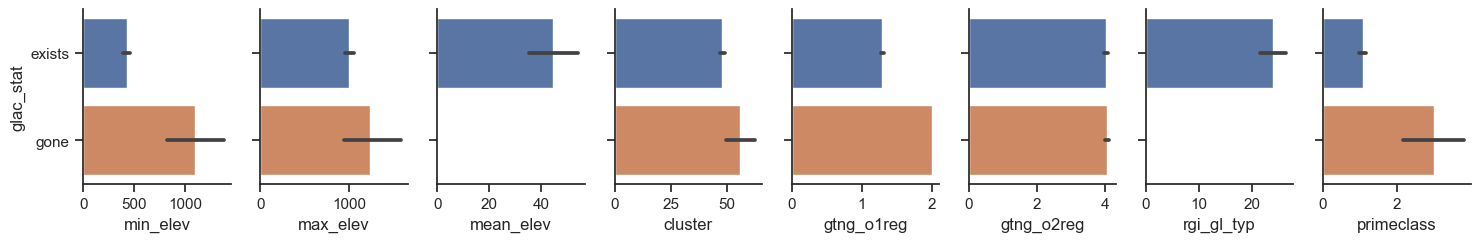

In [100]:
#See influence of variables to target variable
g = sns.PairGrid(clustered_df,
                 x_vars=['min_elev','max_elev','mean_elev','cluster','gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ','primeclass'],
                 y_vars=["glac_stat"],
                 aspect=.75)
#plt.xticks(rotation=90)
g.map(sns.barplot, palette="coolwarm");

C:\Users\cruza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cruza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cruza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cruza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

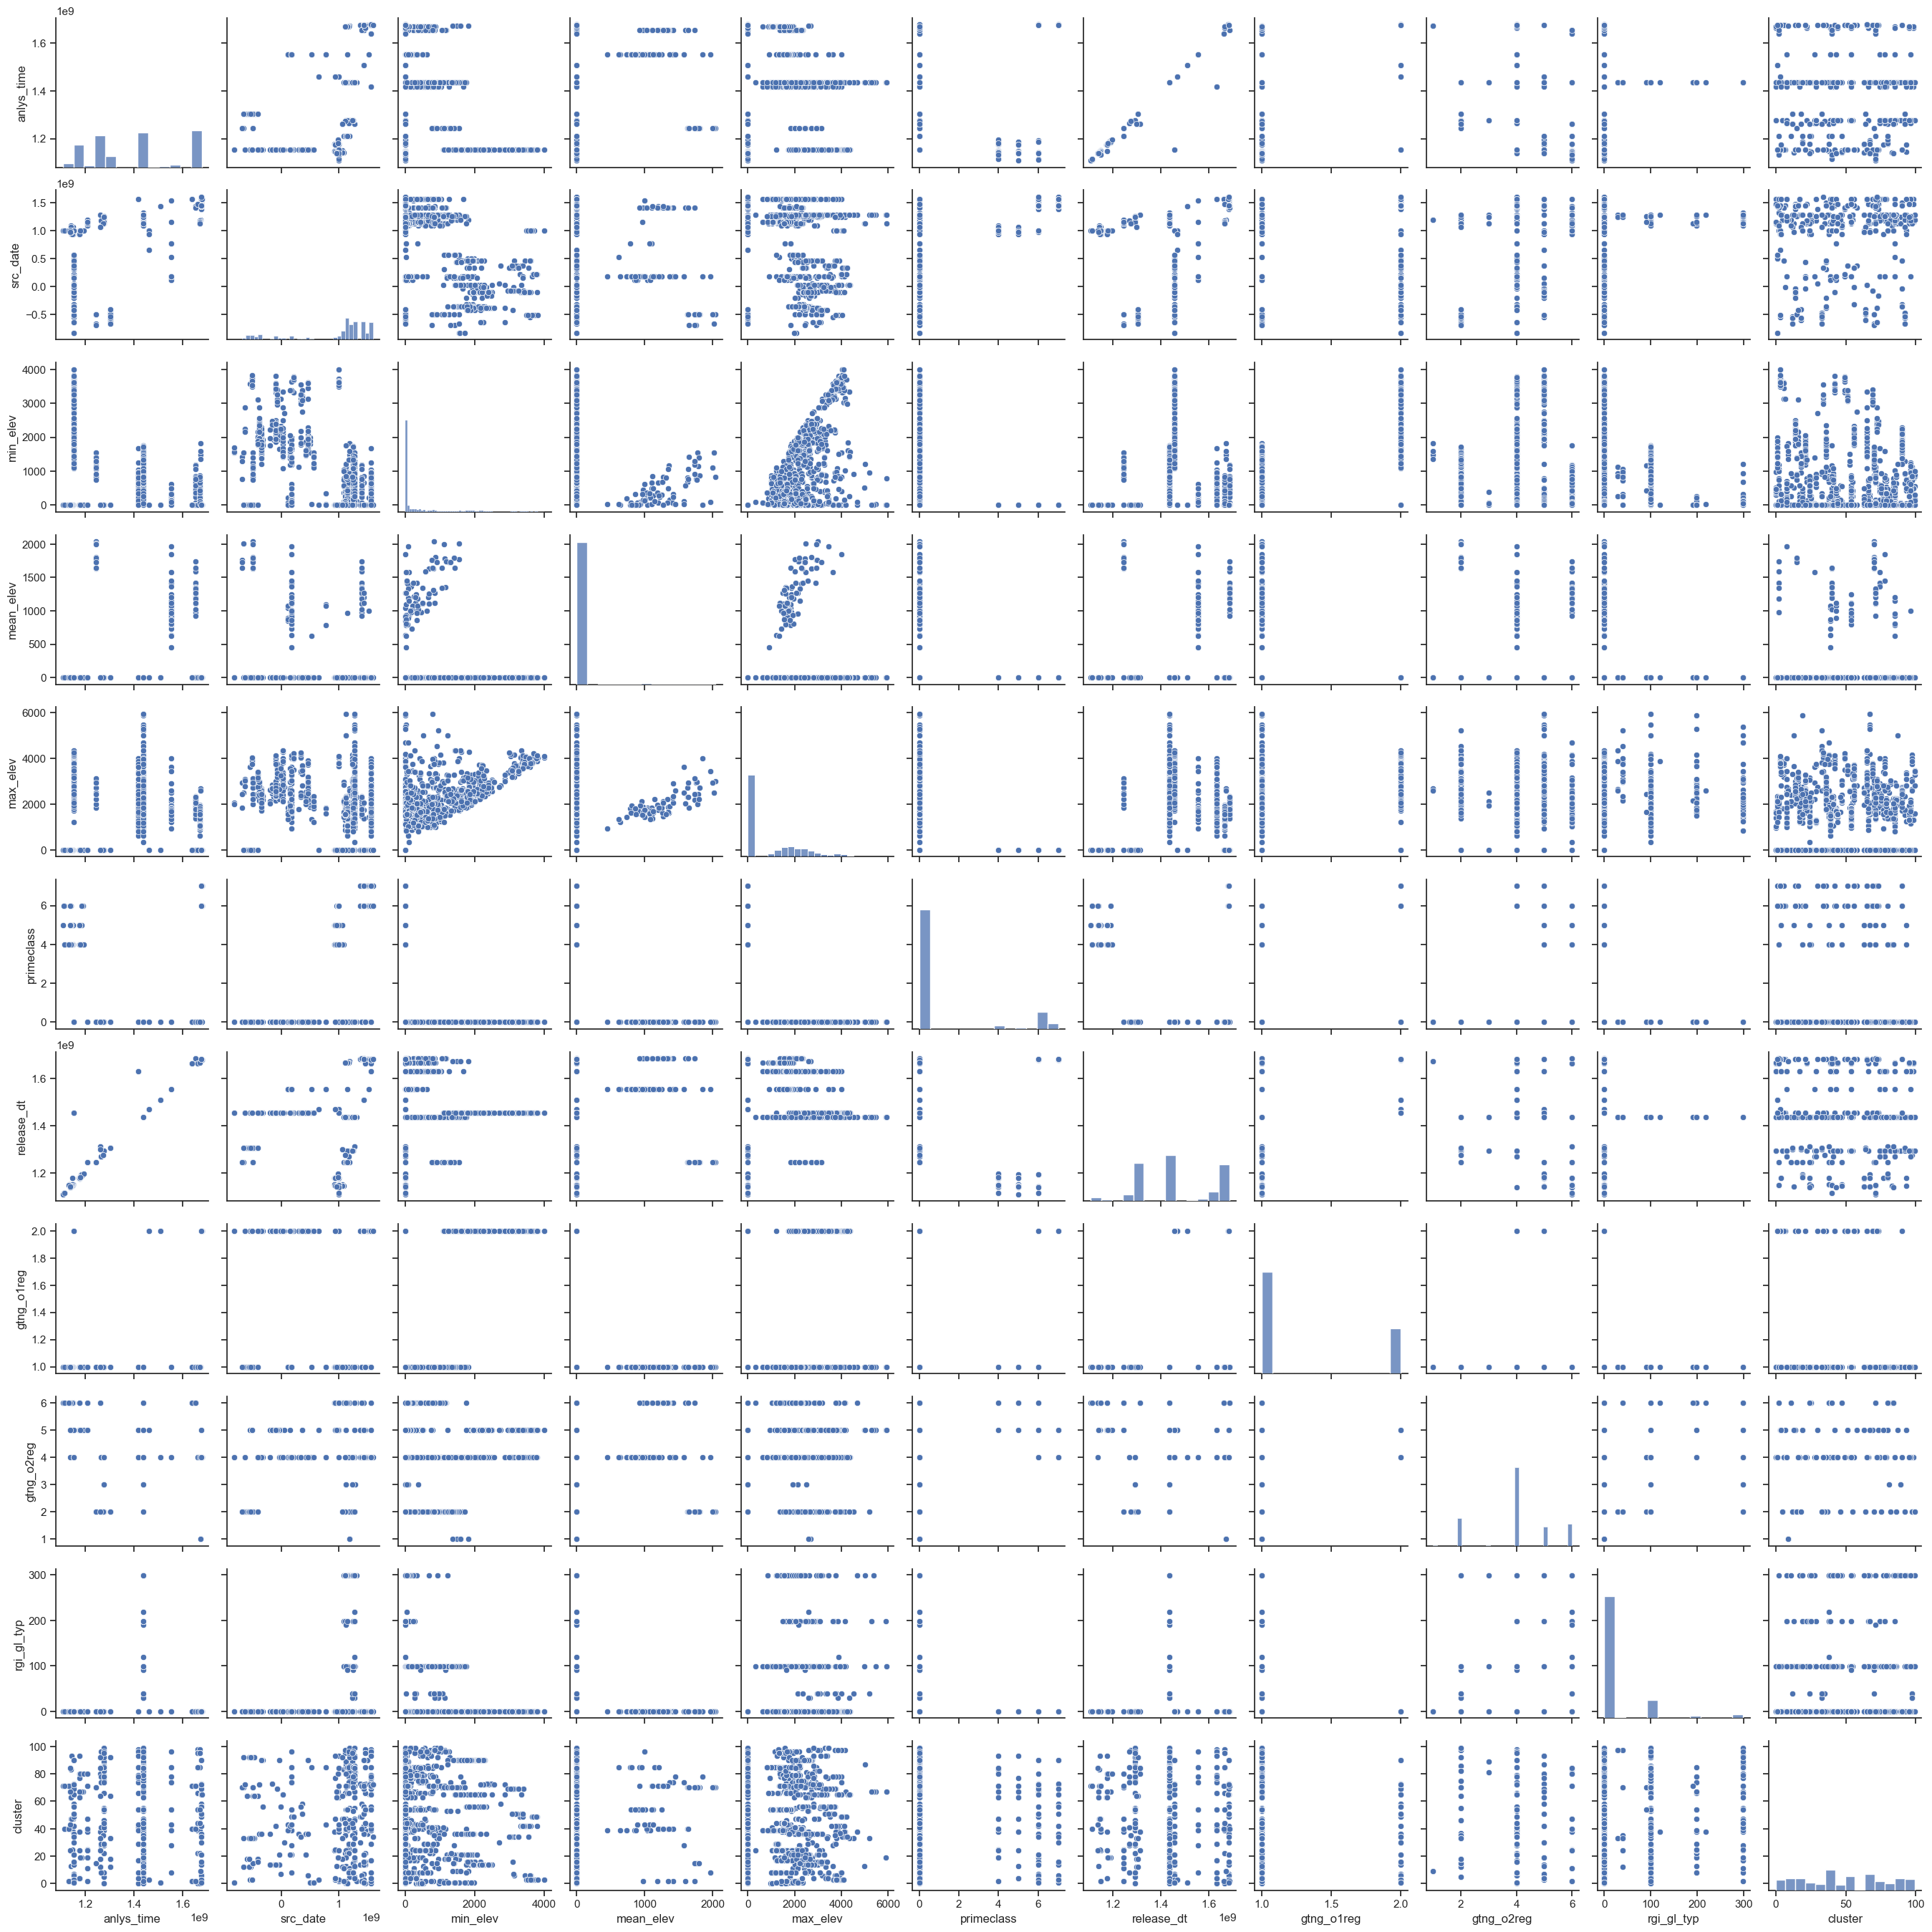

In [103]:
sns.set(style= 'ticks')
cols = ['line_type', 'glac_id', 'anlys_time', 'src_date', 'db_area', 'min_elev',
       'mean_elev', 'max_elev', 'primeclass', 'rec_status', 'release_dt',
       'gone_date', 'glac_name', 'glac_stat', 'geog_area', 'conn_lvl',
       'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ',
       'cluster']
sns.pairplot(clustered_df[cols], height = 2.5)
plt.show();